# Processing - acoustics

In this script, we process the audio files and extract vocalic energy and pitch. We also process the formant data extracted using XXX, and features extracted using XX

In [ ]:
#| code-fold: true
#| code-summary: Code to load packages and prepare the environment

# packages
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.signal import butter, filtfilt

from scipy.signal import hilbert # audio processing
from scipy.interpolate import interp1d
import librosa
import parselmouth

import matplotlib.pyplot as plt
import IPython.display as ipd

curfolder = os.getcwd()
print(curfolder)

# files to work with
ACfolder = curfolder + '\\..\\01_XDF_processing\\data\\Data_processed\\Data_trials\\Audio_48'

# folders to save the processed data
ACfolder_processed = curfolder + '\\TS_acoustics\\'

actotrack = glob.glob(ACfolder + "/*.wav", recursive=True)
#print(actotrack)

# get rid of the first file because it's faulty
actotrack = actotrack[1:]

e:\FLESH_ContinuousBodilyEffort\03_TS_processing


Here is an example

In [ ]:
#| code-fold: true
#| code-summary: Show code

# audio sample
sample = actotrack[10]

ipd.Audio(sample)

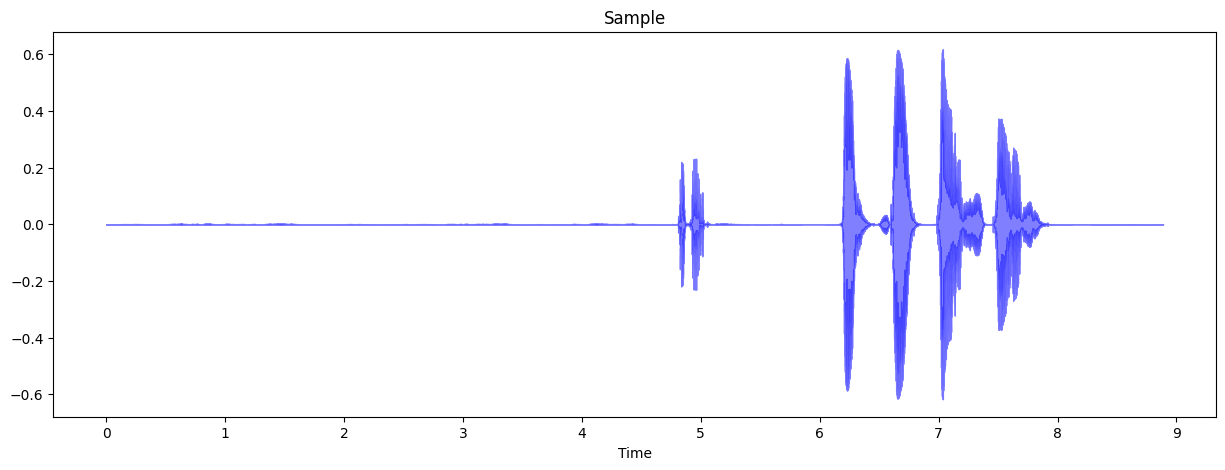

In [ ]:
#| code-fold: true
#| code-summary: Show code for the plot

# visualize the waveform
# from https://www.youtube.com/watch?v=rlypsap6Wow

samp, sr = librosa.load(actotrack[0])

plt.figure(figsize=(15, 17))
plt.subplot(3, 1, 1)
librosa.display.waveshow(samp, color='blue', alpha=0.5)   
plt.title('Sample')
plt.show()

## Extracting vocalic energy

We do XY

REF: https://www.envisionbox.org/embedded_AnimatingSoundMovement.html

In [ ]:
#| code-fold: true
#| code-summary: Code with functions to extract the amplitude envelope

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filtfilt(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Define the lowpass filter
def butter_lowpass(cutoff, fs, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    return b, a

def butter_lowpass_filtfilt(data, cutoff, fs, order=2):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Function to extract amplitude envelope
def amp_envelope(audiofilename):
    # load audio with librosa
    audio, sr = librosa.load(audiofilename, sr=None, mono=True)
    # Bandpass filter 400-4000Hz
    data = butter_bandpass_filtfilt(audio, 400, 4000, sr, order=2)
    # Lowpass filter 10Hz
    data = butter_lowpass_filtfilt(np.abs(data), 10, sr, order=2)
    # scale from 0 to 1
    data = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data, sr

Here is an example how the vocalic energy is extracted

e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_3_Mic_nominal_srate48000_p0_vechten_geluiden.wav


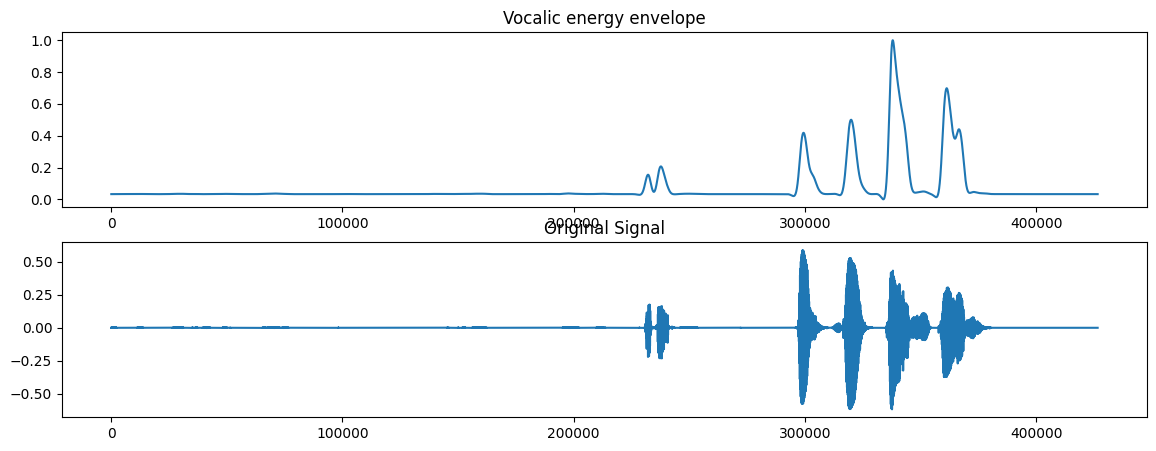

In [ ]:
#| code-fold: true
#| code-summary: Show code for the plot

# Get the amplitude envelope
audiofilename = actotrack[0]
print(audiofilename)
ampv, sr = amp_envelope(audiofilename)
# Plot the filtered signal and the original signal
plt.figure(figsize=(14, 5))
plt.subplot(2, 1, 1)
plt.plot(ampv)
plt.title('Vocalic energy envelope')

# Extract and plot the original signal
rawaudio, sr = librosa.load(audiofilename, sr=None)
plt.subplot(2, 1, 2)
plt.plot(rawaudio)
plt.title('Original Signal')
plt.show()

Now we loop over all the audio files and extract the vocalic energy

In [ ]:
#| code-fold: false
#| code-summary: Code to extract amplitude envelope from audio

# Loop over wav files
for audiofile in actotrack:
    print('working on ' + audiofile)

    # get the trialid
    trialid = audiofile.split('\\')[-1].split('.')[0]
    trialid = '_'.join(trialid.split('_')[0:1] + trialid.split('_')[1:2] + trialid.split('_')[3:4] + trialid.split('_')[7:8])

    # apply the function
    ampv, sr = amp_envelope(audiofile)

    # Extract and plot the original signal
    rawaudio, sr = librosa.load(audiofile, sr=None)

    # create a time vector
    time_env = np.arange(0, len(rawaudio)/sr, 1/sr)
    
    # Ensure the lengths match by padding ampv if necessary - this is a quick fix
    if len(ampv) < len(time_env):
        ampv = np.pad(ampv, (0, len(time_env) - len(ampv)), mode='constant')
    elif len(ampv) > len(time_env):
        ampv = ampv[:len(time_env)]

    # the same for rawaudio
    if len(rawaudio) < len(time_env):
        rawaudio = np.pad(rawaudio, (0, len(time_env) - len(rawaudio)), mode='constant')
    elif len(rawaudio) > len(time_env):
        rawaudio = rawaudio[:len(time_env)]
    
    # save the audio and envelope
    try:
        audio = pd.DataFrame({'time': time_env, 'audio': rawaudio, 'envelope': ampv, 'trialID': trialid})
        # convert time to ms
        audio['time'] = audio['time'] * 1000

        # perform also envelope change
        audio['envelope_change'] = np.insert(np.diff(audio['envelope']), 0, 0)
        # smooth
        audio['envelope_change'] = butter_lowpass_filtfilt(np.abs(audio['envelope_change']), 10, sr, order=2)
        
        # write as csv
        audio.to_csv(ACfolder_processed + '/env_' + trialid + '.csv', index=False)

    except ValueError:
        print('ValueError: ' + trialid)
        continue

audio.head(15)

working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_3_Mic_nominal_srate48000_p0_vechten_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_4_Mic_nominal_srate48000_p0_ademen_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_5_Mic_nominal_srate48000_p0_bijten_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_6_Mic_nominal_srate48000_p0_zoemen_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_7_Mic_nominal_srate48000_p0_fluisteren_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_proc

Here is an example

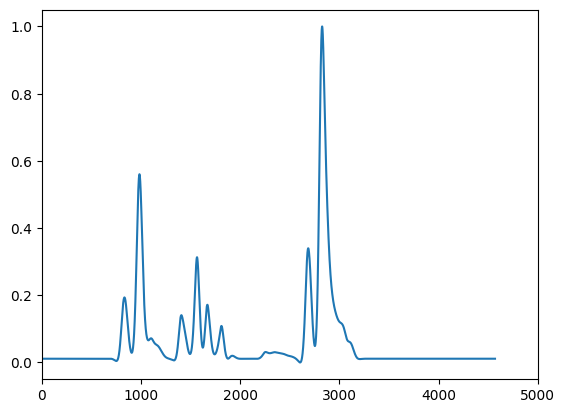

In [ ]:
#| code-fold: true
#| code-summary: Show code for the plot

# plot to check
plt.plot(audio['time'], audio['envelope'])
plt.xlim(0, 5000)
plt.show()

## Extracting pitch (f0)

Now we extract pitch using the `parselmouth` library.

In [ ]:
#| code-fold: true
#| code-summary: Code with function to extract the fundamental frequency

def extract_f0(locationsound, sex):
    # read the sound file into Python
    snd = parselmouth.Sound(locationsound)

    if sex == 'f':
        f0min = 30      ## ranges from Praat script, check soundgen_features RMarkdown for calculation
        f0max = 650
    else:
        f0min = 30      ## Note: don't have any males in dyad0 so this is only placeholder
        f0max = 650

    pitch = snd.to_pitch(pitch_floor=f0min, pitch_ceiling=f0max)

    f0_values = pitch.selected_array['frequency']

    return snd, f0_values

We loop over all audio files and extract pitch from each. Note that we take into consideration the sex of participant to set the pitch range accordingly. The range has been checked in Praat with XXX

In [ ]:
#| code-fold: true
#| code-summary: Code to extract the fundamental frequency

freq=48000    
meta = pd.read_csv(curfolder + '\\..\\00_RAWDATA\\META.txt', sep='\t')

# Loop over wav files
for audiofile in actotrack:
    print('working on ' + audiofile)

    # get the trialid
    trialid = audiofile.split('\\')[-1].split('.')[0]
    #trial id is the first, second, fourth and eighth element
    trialid = '_'.join(trialid.split('_')[0:1] + trialid.split('_')[1:2] + trialid.split('_')[3:4] + trialid.split('_')[7:8])

    # first element is sessionid, fourth element is participantid
    sessionid = trialid.split('_')[0]
    participantid = trialid.split('_')[3]
    ID = sessionid + '_' + participantid

    # what sex has this ID in meta
    sex = meta[meta['ID'] == ID]['sex'].values[0]

    # apply the function
    snd, f0 = extract_f0(audiofile, sex)

    length = len(f0)

    # replace 0 values with NaN
    f0 = np.where(f0 == 0, np.nan, f0)

    # create time vector
    F0_time = np.linspace(0, snd.duration, len(f0)) * 1000  # Generate time vector

    # create df
    f0_df = pd.DataFrame({'time_ms': F0_time, 'f0': f0, 'ID': trialid})

    #### smoothing
    # parse into chunks of non-NaN values
    # create a new column for storing chunk number
    f0_df['chunk'] = None

    chunk = 0
    for index, row in f0_df.iterrows():
        if np.isnan(row['f0']):
            continue
        else:
            f0_df.loc[index, 'chunk'] = chunk
            # if the next value is NaN or this is the last row, increase the chunk
            if index == len(f0_df)-1:
                continue
            elif np.isnan(f0_df.loc[index+1, 'f0']):
                chunk += 1

    # now we can smooth the f0 values in each chunk
    chunks = f0_df['chunk'].unique()

    # skip if chunks are empty (that means that there is no f0 trace)
    if len(chunks) > 1:
        # ignore the first chunk (None)
        chunks = chunks[1:]
        for chunk in chunks:
            # get the rows of the chunk
            chunkrows = f0_df[f0_df['chunk'] == chunk].copy()
            # dont smooth chunks shorter than 5
            if len(chunkrows) < 5:
                continue
            else:
                # smooth f0 with savgol 5, 3
                chunkrows['f0'] = scipy.signal.savgol_filter(chunkrows['f0'], 5, 3) 
                # put it back to the samplef0
                f0_df.loc[f0_df['chunk'] == chunk, 'f0'] = chunkrows['f0']

    # get rid of the chunk column
    f0_df = f0_df.drop('chunk', axis=1)
    # write as csv
    f0_df.to_csv(ACfolder_processed + '/f0_' + trialid + '.csv', index=False)

f0_df.head(15)

working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_3_Mic_nominal_srate48000_p0_vechten_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_4_Mic_nominal_srate48000_p0_ademen_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_5_Mic_nominal_srate48000_p0_bijten_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_6_Mic_nominal_srate48000_p0_zoemen_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_processed\Data_trials\Audio_48\0_1_trial_7_Mic_nominal_srate48000_p0_fluisteren_geluiden.wav
working on e:\FLESH_ContinuousBodilyEffort\03_TS_processing\..\01_XDF_processing\data\Data_proc

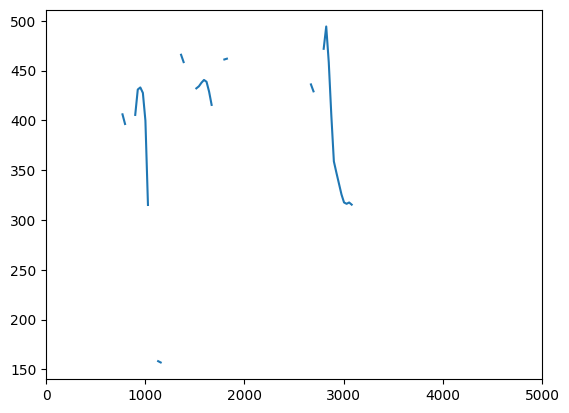

In [ ]:
#| code-fold: true
#| code-summary: Show code for the plot

# plot to check
plt.plot(f0_df['time_ms'], f0_df['f0'])
plt.xlim(0, 5000)
plt.show()